In [4]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.08G/3.10G [00:34<00:00, 257MB/s]
100% 3.10G/3.10G [00:34<00:00, 95.9MB/s]


In [6]:
from zipfile import ZipFile
with ZipFile('/content/breast-histopathology-images.zip','r')  as file:
  file.extractall()

In [7]:
import os
import shutil
from tqdm import tqdm

source_root = '/content/IDC_regular_ps50_idx5'  # base folder after unzip
output_0 = './merged_dataset/0'
output_1 = './merged_dataset/1'

os.makedirs(output_0, exist_ok=True)
os.makedirs(output_1, exist_ok=True)

# Traverse all patient folders
patient_dirs = [d for d in os.listdir(source_root) if os.path.isdir(os.path.join(source_root, d))]

for patient in tqdm(patient_dirs):
    class_0_dir = os.path.join(source_root, patient, '0')
    class_1_dir = os.path.join(source_root, patient, '1')

    if os.path.exists(class_0_dir):
        for f in os.listdir(class_0_dir):
            shutil.copy(os.path.join(class_0_dir, f), os.path.join(output_0, f"{patient}_0_{f}"))

    if os.path.exists(class_1_dir):
        for f in os.listdir(class_1_dir):
            shutil.copy(os.path.join(class_1_dir, f), os.path.join(output_1, f"{patient}_1_{f}"))


100%|██████████| 279/279 [01:10<00:00,  3.95it/s]


In [8]:
import os
import shutil
import random
from tqdm import tqdm

input_dir = 'merged_dataset'
output_dir = 'dataset_split'
classes = ['0', '1']
split_ratio = 0.8  # 80% train, 20% test

for cls in classes:
    images = os.listdir(os.path.join(input_dir, cls))
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_imgs = images[:split_index]
    test_imgs = images[split_index:]

    train_cls_dir = os.path.join(output_dir, 'train', cls)
    test_cls_dir = os.path.join(output_dir, 'test', cls)

    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for img in tqdm(train_imgs, desc=f"Copying train/{cls}"):
        src = os.path.join(input_dir, cls, img)
        dst = os.path.join(train_cls_dir, img)
        shutil.copy(src, dst)

    for img in tqdm(test_imgs, desc=f"Copying test/{cls}"):
        src = os.path.join(input_dir, cls, img)
        dst = os.path.join(test_cls_dir, img)
        shutil.copy(src, dst)


Copying test/1: 100%|██████████| 15758/15758 [00:03<00:00, 5099.09it/s]


In [1]:
import tensorflow as tf

img_size = (64, 64)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 222018 files belonging to 2 classes.
Found 55506 files belonging to 2 classes.


In [2]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Is Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.test.is_gpu_available(cuda_only=True))

# Set memory growth (best practice)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available: 1
Is Built with CUDA: True
GPU Available: True
Physical devices cannot be modified after being initialized


In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [6]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 198s 7ms/step - accuracy: 0.8158 - loss: 0.4241 - val_accuracy: 0.8498 - val_loss: 0.3586
Epoch 2/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - accuracy: 0.8481 - loss: 0.3589 - val_accuracy: 0.8559 - val_loss: 0.3445
Epoch 3/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - accuracy: 0.8557 - loss: 0.3450 - val_accuracy: 0.8618 - val_loss: 0.3327
Epoch 4/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 139s 5ms/step - accuracy: 0.8593 - loss: 0.3387 - val_accuracy: 0.8641 - val_loss: 0.3262
Epoch 5/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 159s 6ms/step - accuracy: 0.8616 - loss: 0.3306 - val_accuracy: 0.8641 - val_loss: 0.3218
Epoch 6/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 139s 5ms/step - accuracy: 0.8634 - loss: 0.3290 - val_accuracy: 0.8650 - val_loss: 0.3218
Epoch 7/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 139s 5ms/step - accuracy: 0.8645 - loss: 0.3261 - val_accuracy: 0.8633 - val_loss: 0.3369
Epoch 8/10
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 155s 6ms/step - ac

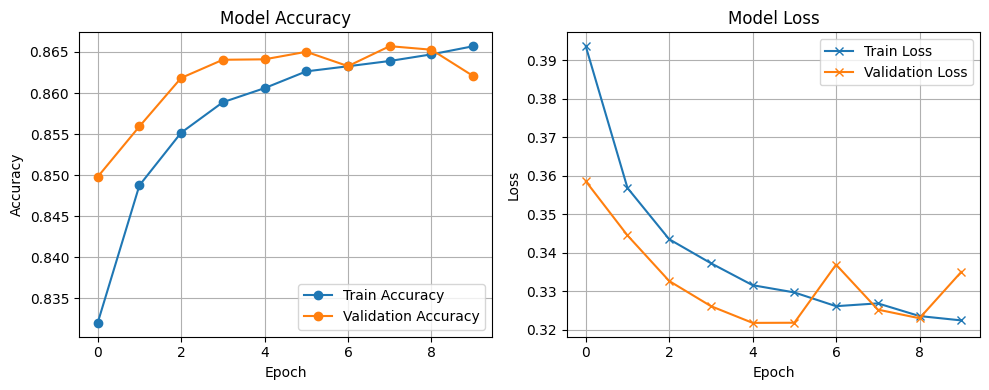

In [7]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8627 - loss: 0.3330
Test Accuracy: 0.8621


In [10]:
model.save("cnn_based_breast_cancer_pred.h5")
